# Проектная работа: A/B-тестирование

### Задача:

Провести оценку результатов A/B-теста. 

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
Необходимо оценить корректность проведения теста и проанализировать его результаты.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Описание данных

1. `ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

2. `final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

3. `final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

4. `final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

### Инструкция:

1. Загрузка данных, просмотр и изучение
2. Предобработка данных
3. Оценка соответствия теста техническому заданию
4. Исследовательский анализ данных
5. Исследование конверсии в воронке на разных этапах
6. A/B-тестирование
7. Общий вывод

## 1. Загрузка данных, просмотр и изучение

In [48]:
# загружаем необходимые библиотеки
import pandas as pd                                         # для анализа данных
import numpy as np                                          # для математических вычислений
import math as mth                                          # для математических вычислений

import seaborn as sns                                       # для визуализации данных
import matplotlib.pyplot as plt                             # для визуализации
from plotly import graph_objects as go                      # для визуализации

import datetime as dt                                       # для преобразования к типу данных 'дата'
from datetime import timedelta

from scipy import stats as st                               # для высокоуровневых математических вычислений 
from statsmodels.stats.proportion import proportions_ztest  # статистика пропорции z-тест, метод статистической проверки гипотез

import warnings                                             # для предупреждений в программе 
warnings.filterwarnings('ignore')                           # фильтр предупреждений

In [49]:
# загружаем данные
try:
    calendar, users, actions, participants = (
    pd.read_csv('/datasets/ab_project_marketing_events.csv'),  # календарь маркетинговых событий на 2020 год
    pd.read_csv('/datasets/final_ab_new_users.csv'),           # пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года
    pd.read_csv('/datasets/final_ab_events.csv'),              # действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
    pd.read_csv('/datasets/final_ab_participants.csv')         # таблица участников тестов
)
except:
    calendar, users, actions, participants = (
    pd.read_csv('C:/py/Дипломный проект/AB-тестирование/ab_project_marketing_events.csv'),  # календарь маркетинговых событий на 2020 год
    pd.read_csv('C:/py/Дипломный проект/AB-тестирование/final_ab_new_users.csv'),           # пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года
    pd.read_csv('C:/py/Дипломный проект/AB-тестирование/final_ab_events.csv'),              # действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
    pd.read_csv('C:/py/Дипломный проект/AB-тестирование/final_ab_participants.csv')         # таблица участников тестов
)

In [50]:
# создадим функцию для первичного анализа данных датафрема с календарем маркетинговых событий на 2020 год, посмотрим распределение численных значений,
# приведём названия к нижнему регистру, проверим на дубликаты и пропуски
def information(calendar):
    calendar.info()
    column=calendar.describe().columns
    display(calendar.describe())
    for index in calendar.columns:
        if index not in column:
            calendar[index] = calendar[index].str.lower()
    print ('Количество явных дубликатов -', calendar.duplicated().sum())
    print ('Количество пропусков -', calendar.isna().sum())
    return calendar

In [51]:
information(calendar)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


Количество явных дубликатов - 0
Количество пропусков - name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Таблица состоит из 14 строк и 4 столбцов. Присутствует некорректный тип в столбцах с датой и временем, необходимо изменить.

In [52]:
# создадим функцию для первичного анализа данных датафрейма с пользователями, зарегистрировавших с 7 до 21 декабря 2020 года, посмотрим распределение численных значений,
# приведём названия к нижнему регистру, проверим на дубликаты и пропуски
def information(users):
    users.info()
    column=users.describe().columns
    display(users.describe())
    for index in users.columns:
        if index not in column:
            users[index] = users[index].str.lower()
    print ('Количество явных дубликатов -', users.duplicated().sum())
    print ('Количество пропусков -', users.isna().sum())
    return users

In [53]:
information(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


Количество явных дубликатов - 0
Количество пропусков - user_id       0
first_date    0
region        0
device        0
dtype: int64


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


Таблица состоит из 61733 строк и 4 столбцов, так же некорректный тип столбца даты и времени, необходимо изменить на правильный.

In [54]:
# создадим функцию для первичного анализа данных датафрейма с действиями новых пользователей в период с 7 декабря 2020 по 4 января 2021 года, посмотрим распределение численных значений,
# приведём названия к нижнему регистру, проверим на дубликаты и пропуски
def information(actions):
    actions.info()
    column=actions.describe().columns
    display(actions.describe())
    for index in actions.columns:
        if index not in column:
            actions[index] = actions[index].str.lower()
    print ('Количество явных дубликатов -', actions.duplicated().sum())
    print ('Количество пропусков -', actions.isna().sum())
    return actions

In [55]:
information(actions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


Количество явных дубликатов - 0
Количество пропусков - user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


,user_id,event_dt,event_name,details
0,e1bddce0dafa2679,2020-12-07 20:22:03,purchase,99.99
1,7b6452f081f49504,2020-12-07 09:22:53,purchase,9.99
2,9cd9f34546df254c,2020-12-07 12:59:29,purchase,4.99
3,96f27a054b191457,2020-12-07 04:02:40,purchase,4.99
4,1fd7660fdf94ca1f,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245e85f65c358e08,2020-12-30 19:35:55,login,NaN
440313,9385a108f5a0a7a7,2020-12-30 10:54:15,login,NaN
440314,db650b7559ac6eac,2020-12-30 10:59:09,login,NaN
440315,f80c9bddea02e53c,2020-12-30 09:53:39,login,NaN


Таблица состоит из 440317 строк и 4 столбцов, так же некорректный тип столбца даты и времени, необходимо изменить на правильный.
Присутствуют пропущенные значения: 377577 строк в столбце с дополнительными данными о событии, необходимо отдельно посмотреть.

In [56]:
# создадим функцию для первичного анализа данных датафрейма с таблицей участников тестов, посмотрим распределение численных значений,
# приведём названия к нижнему регистру, проверим на дубликаты и пропуски
def information(participants):
    participants.info()
    column=participants.describe().columns
    display(participants.describe())
    for index in participants.columns:
        if index not in column:
            participants[index] = participants[index].str.lower()
    print ('Количество явных дубликатов -', participants.duplicated().sum())
    print ('Количество пропусков -', participants.isna().sum())
    return participants

In [57]:
information(participants)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


Количество явных дубликатов - 0
Количество пропусков - user_id    0
group      0
ab_test    0
dtype: int64


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


Таблица состоит из 18268 строк (это наблюдений) и 3 столбцов.

**Вывод по разделу:**

Загрузили и изучили данные, выявили некооректный тип в столбцах с датой и временем и так же обнаружены пропущенные значения в датафрейме с действиями новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

## 2. Предобработка данных

In [58]:
# изменим тип данных на datetime 
calendar['start_dt'] = pd.to_datetime(calendar['start_dt'])
calendar['finish_dt'] = pd.to_datetime(calendar['finish_dt'])
users['first_date'] = pd.to_datetime(users['first_date'])
actions['event_dt'] = pd.to_datetime(actions['event_dt'])

In [59]:
# убедимся, что тип изменился на правильный
calendar.info()
users.info()
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total

In [60]:
# посмотрим столбец на уникальные в котором присутствует много пропусков
actions['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

Так как это столбец с дополнительными данными, то скорее всего этот столбец заполняется когда есть дополнительная информация, поэтому пропуски в данном столбце приемлены, оставим их.

**Вывод по разделу:**

Заменены типы столбцов с датами на корректный. По пропускам приняли решение оставить.

## 3. Оценка соответствия теста техническому заданию:

- Соединение таблицы:

In [61]:
# приведём к нижнему регистру данные в столбце с идентификатором пользователя
users['user_id'] = users['user_id'].str.lower()
actions['user_id'] = actions['user_id'].str.lower()
participants['user_id'] = participants['user_id'].str.lower()

In [62]:
# соединим три таблицы в одну общую по столбцу пользователи
data = pd.merge(actions, users, on='user_id', how='left')
data = pd.merge(data, participants, on='user_id', how='left')
# приведём столбец с датой события в другой формат без времени
data['event_dt'] = data['event_dt'].dt.strftime('%Y-%m-%d')
data

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,e1bddce0dafa2679,2020-12-07,purchase,99.99,2020-12-07,N.America,iPhone,NaN,NaN
1,7b6452f081f49504,2020-12-07,purchase,9.99,2020-12-07,EU,iPhone,NaN,NaN
2,9cd9f34546df254c,2020-12-07,purchase,4.99,2020-12-07,N.America,iPhone,NaN,NaN
3,96f27a054b191457,2020-12-07,purchase,4.99,2020-12-07,EU,iPhone,B,interface_eu_test
4,1fd7660fdf94ca1f,2020-12-07,purchase,4.99,2020-12-07,EU,Android,NaN,NaN
...,...,...,...,...,...,...,...,...,...
446206,245e85f65c358e08,2020-12-30,login,NaN,2020-12-07,EU,Android,NaN,NaN
446207,9385a108f5a0a7a7,2020-12-30,login,NaN,2020-12-07,EU,PC,NaN,NaN
446208,db650b7559ac6eac,2020-12-30,login,NaN,2020-12-07,EU,Android,NaN,NaN
446209,f80c9bddea02e53c,2020-12-30,login,NaN,2020-12-07,EU,iPhone,A,interface_eu_test


- Проверим на распредление и пересечение пользователей по тестам. Дальнейший анализ будем проводить с группой рекомендательной системы: 

In [63]:
# посчитаем распределение по группе тестов
data['ab_test'].value_counts()

interface_eu_test          81927
recommender_system_test    24698
Name: ab_test, dtype: int64

In [64]:
# посмотрим пересечение тестовой аудитории с конкурирующим тестом
intersection_num = data.groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test == 2').reset_index()
intersection_num

,user_id,ab_test
0,001064feaab631a1,2
1,00341d8401f0f665,2
2,0082295a41a867b5,2
3,00e68f103c66c1f7,2
4,00efa157f7b6e1c4,2
...,...,...
882,fea0c585a53e7027,2
883,fec0bca6c323872f,2
884,ff2174a1aa0ead20,2
885,ff44696e39039d29,2


In [65]:
intersection = pd.merge(intersection_num, data, on=['user_id'], how='inner')
intersection = intersection.groupby(['user_id','ab_test_y', 'group']).agg({'event_dt':'count'}).reset_index()
intersection = intersection.query('ab_test_y == "recommender_system_test"')
intersection
intersection2 = intersection.groupby(['group']).agg({'user_id':'count'})
intersection2.reset_index()

,group,user_id
0,A,665
1,B,222


In [66]:
# проверяем распределение пользовалтелей в группах для пересекающихся пользователей
print ('Количество пользователей в группе A = ', len(intersection.query('group == "A"')))
print ('Количество пользователей в группе B = ', len(intersection.query('group == "B"')))
print ('Доля пользователей группы A  = ', round(len(intersection.query('group == "A"')) / len (intersection), 2))
print ('Доля пользователей группы B  = ', round(len(intersection.query('group == "B"')) / len (intersection), 2))

Количество пользователей в группе A =  665
Количество пользователей в группе B =  222
Доля пользователей группы A  =  0.75
Доля пользователей группы B  =  0.25


In [67]:
# проверяем распределение пользовалтелей в группах общего датафрейма
group_users_count = data.groupby(['user_id', 'group']).agg({'event_dt':'count'}).reset_index()
print ('Количество пользователей в группе A = ', len(group_users_count.query('group == "A"')))
print ('Количество пользователей в группе B = ', len(group_users_count.query('group == "B"')))
print ('Доля пользователей группы A  = ', round(len(group_users_count.query('group == "A"')) / len (group_users_count), 2))
print ('Доля пользователей группы B  = ', round(len(group_users_count.query('group == "B"')) / len (group_users_count), 2))
group_users_count = data.groupby('group').agg({'user_id': ['nunique']}).reset_index().sort_values(by= ('user_id', 'nunique'), ascending=False)
group_users_count.columns = ['group', 'n_users']
display(group_users_count)

Количество пользователей в группе A =  7874
Количество пользователей в группе B =  6205
Доля пользователей группы A  =  0.56
Доля пользователей группы B  =  0.44


,group,n_users
0,A,7874
1,B,6205


In [68]:
# посмотрим пересечение тестовой аудитории "recommender_system_test" между группами
intersection_num = data.query('ab_test=="recommender_system_test"').groupby('user_id').agg({'group':'nunique'}).query('group == 2').reset_index()
print (f'Количество участников в 2х группах: {len(intersection_num)}')

Количество участников в 2х группах: 0


нет пользователей участвующих одновременно в 2х группах А\В нашего теста.

Провели дополнительный анализ для пересекающихся пользователей. В распределении видно, что отношение количества пользователей в группах датасета такое же, как и в распределении по проверке пересекающихся пользователей в тестах. Т.к. отношение 75 \ 25 одинаковое, то считаю, что необходимо оставить таких пользователей. Так же наблюдается несоответствие исходных данных с условием ТЗ о необходимом количестве участников (6000). При удалении их будет еще меньше.

In [69]:
# отберём тестовую группу 
data = data.query('ab_test=="recommender_system_test"')
data

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
5,831887fe7f2d6cba,2020-12-07,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test
17,3c5dd0288ac4fe23,2020-12-07,purchase,4.99,2020-12-07,EU,PC,A,recommender_system_test
58,49ea242586c87836,2020-12-07,purchase,99.99,2020-12-07,EU,iPhone,B,recommender_system_test
71,2b06eb547b7aad08,2020-12-07,purchase,4.99,2020-12-07,EU,PC,A,recommender_system_test
75,a640f31cac7823a6,2020-12-07,purchase,4.99,2020-12-07,EU,PC,B,recommender_system_test
...,...,...,...,...,...,...,...,...,...
446131,d21f0d4fdcd82db2,2020-12-29,login,NaN,2020-12-20,EU,iPhone,A,recommender_system_test
446150,96bdd55846d1f7f6,2020-12-29,login,NaN,2020-12-20,EU,iPhone,A,recommender_system_test
446160,553bae96c6eb6240,2020-12-29,login,NaN,2020-12-20,EU,Android,A,recommender_system_test
446174,dd4352cdcf8c3d57,2020-12-30,login,NaN,2020-12-07,EU,Android,B,recommender_system_test


In [70]:
# посчитаем общее количество пользователей после фильтрации
users_total = len(data['user_id'].unique())
print("Всего пользователей после фильтрации: {} пользователей".format(users_total))

Всего пользователей после фильтрации: 3675 пользователей


In [71]:
# посчитаем распределение событий по группе тестов
data['group'].value_counts()

A    19304
B     5394
Name: group, dtype: int64

In [72]:
# посчитаем уникальных пользователей из таблицы таблицы участников тестов 
data['ab_test'].value_counts()

recommender_system_test    24698
Name: ab_test, dtype: int64

- проверим, все ли пользователи, зарегистрированные в тесте, совершали за период проведения теста события:

In [73]:
# посчитаем количество пользователей не вошедших в дальнейший анализ 
bad_users = len(participants.query('ab_test == "recommender_system_test"')) - len(data['user_id'].unique())
print(f'Пользователи зарегистрированные в тесте, НО не совершали за период проведения теста события: {bad_users}')

Пользователи зарегистрированные в тесте, НО не совершали за период проведения теста события: 3026


Вывод:

Из 6701 участников теста исключили из анализа 3026 пользователей не совершавших ни одного действия.

- проверим, что в тест отобрано 15% новых пользователей из региона EU:

In [74]:
# посчитаем количество всех новых пользователей из EU
data_eu = len(data.query('region == "EU"')) 
# найдем аудиторию из EU
auditorium_eu = data.groupby('region').agg({'user_id':'nunique'}).loc['EU', 'user_id']
prc = auditorium_eu / data_eu
print("Процент новых пользователей из региона EU: {:.0%}".format(prc))

Процент новых пользователей из региона EU: 15%


 Как видим совпадает процент новых пользователей из региона EU.

- Проверим, были ли во время проведения теста маркетинговые мероприятия, которые могли бы повлиять на результат:

In [75]:
# создадим переменные начало, конец, и конец набора пользователей
t_start = dt.date(2020, 12, 7)
t_finish = dt.date(2021, 1, 4)
reg_finish = dt.date(2020, 12, 21)

In [76]:
# отфильтруем датасет на нужные даты
calendar = calendar[(calendar['start_dt'] <= "2021-01-04") & 
                                          (calendar['finish_dt'] >= "2020-12-07")]
calendar

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Во время набора пользователей на тест проходили 2 маркетинговых мероприятия в период с 25 декабря до 3 января - рождественское и новогоднее промо в Европе и Североной Америке. И новогодняя лотерея в СНГ. Возможно, эти акции повлияли на активность пользователей в последнюю неделю теста.

- По условию ТЗ дата остановки набора новых пользователей должна быть 21 декабря 2020. Уберем пользователей зарегистрировавшихся после 21 декабря:

In [77]:
# оставим пользователей по 21-12-2020.
data = data.query('first_date <= "2020-12-21"')
# оставим только регион EU
data = data.query('region == "EU"')
# найдем минимальную и максимальную дату
min_first_date = data['first_date'].min()
max_first_date = data['first_date'].max()

print("Дата первой записи в логе после фильтрации:: {} ".format(min_first_date))
print("Дата последней записи в логе после фильтрации:: {} ".format(max_first_date))
print("Период ведения лога после фильтрации: {} ".format(max_first_date - min_first_date))

Дата первой записи в логе после фильтрации:: 2020-12-07 00:00:00 
Дата последней записи в логе после фильтрации:: 2020-12-21 00:00:00 
Период ведения лога после фильтрации: 14 days 00:00:00 


- По условию ТЗ активных дней для каждого пользователя должно быть не более 14 дней. Уберем остальные события.

In [78]:
# делаем фильтр в 14 дней

print(f'пользователей : {data.user_id.nunique()} -  событий: {data.event_dt.count()}')
data['first_date'] = pd.to_datetime(data['first_date'])
data['event_dt1'] = pd.to_datetime(data['event_dt'])

# вычисляем дату, до которой нужно оставить события
data['lifetime'] = data['first_date'] + dt.timedelta(days=14)

# фильтруем DataFrame по дате события
data = data[data['event_dt1'] <= data['lifetime']]

# удаляем столбец с датой отсечки
data.drop('lifetime', axis=1, inplace=True)
print(f'пользователей : {data.user_id.nunique()} -  событий: {data.event_dt.count()}')


пользователей : 3481 -  событий: 23420
пользователей : 3481 -  событий: 22828


## 4. Исследовательский анализ  данных

- Анализ событий:

In [79]:
# посчитаем общее количество событий
number_events = len(data)
print("Всего событий в логе: {} событий".format(number_events))
# посчитаем общее количество пользователей
number_users = len(data['user_id'].unique())
print("Всего пользователей в логе: {} пользователей".format(number_users))
print("В среднем на одного пользователя приходится: {} событий".format(round(number_events/number_users)))

Всего событий в логе: 22828 событий
Всего пользователей в логе: 3481 пользователей
В среднем на одного пользователя приходится: 7 событий


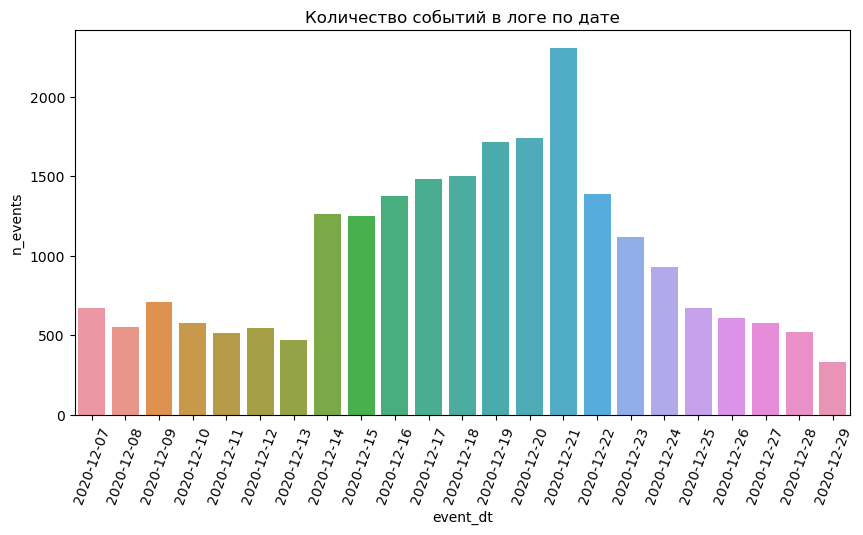

In [80]:
# сгруппируем данные по event_date и посчитаем количество событий
number_events = data.groupby('event_dt').agg({'event_name': ['count']}).reset_index()
number_events.columns = ['event_dt', 'n_events']
# применим метод dt.strftime() — он превращает объект Series с типом datetime в строку в формате даты 
#number_events['event_dt'] = number_events['event_dt'].dt.strftime('%Y-%m-%d')
# строим график
plt.figure(figsize=(10,5))
plt.title('Количество событий в логе по дате') 
sns.barplot(x='event_dt', y='n_events', data=number_events)
plt.xticks(rotation= 70)
plt.show()

По графику видно, что после 29 декабря 2020 года неполные данные. По ТЗ для тестирования нужно, чтобы были полные данные до 4 января 2021 год. Скорее всего произошел какой-то сбой в записи событий. Не будем учитывать эти неполные данные и уберём такие события после 29 декабря.

In [81]:
# отфильтруем данные, оставив до 29 декабря
data = data.query('event_dt <= "2020-12-29"')

In [82]:
# посчитаем общее количество событий после фильтрации
events_total = len(data)
print("Всего событий в логе после фильтрации: {} событий".format(events_total))

# Посчитаем общее кол-во пользователей после фильтрации.
users_events_total = len(data['user_id'].unique())
print("Всего пользователей в логе после фильтрации: {} пользователей".format(users_events_total))
print("В среднем на одного пользователя приходится после фильтрации: {} событий".format(
    int(data.groupby('user_id').agg({'event_name':'count'})['event_name'].mean())))

Всего событий в логе после фильтрации: 22828 событий
Всего пользователей в логе после фильтрации: 3481 пользователей
В среднем на одного пользователя приходится после фильтрации: 6 событий


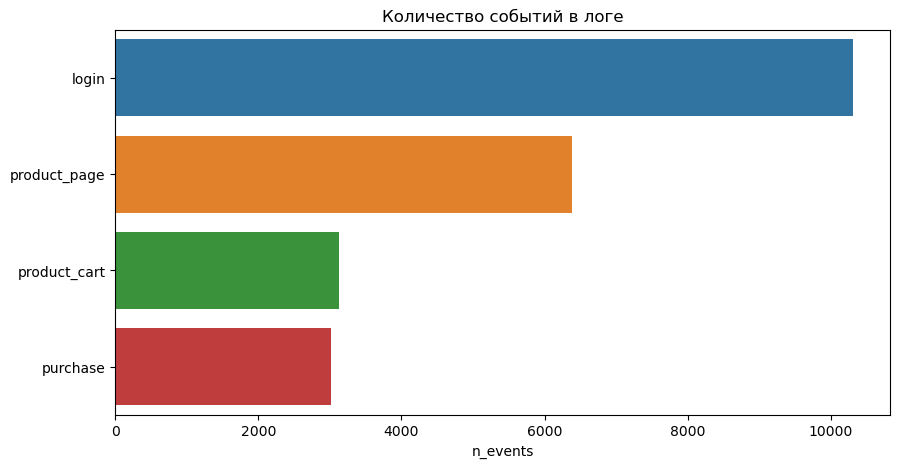

In [83]:
# сгруппируем по событию и посчитаем количество записей для каждого события
number_entries = data.groupby('event_name').agg({'event_dt':'count'}).reset_index().sort_values(by='event_dt', ascending=False)
number_entries.columns = ['event_name', 'n_events']
# посчитаем долю событий от общего количества
number_entries['share_events'] = ((number_entries['n_events'] / number_entries['n_events'].sum()) * 100).round(2)
# построим график
plt.figure(figsize=(10, 5))
plt.title('Количество событий в логе') 
sns.barplot(x='n_events', y=['login', 'product_page', 'product_cart', 'purchase'], data=number_entries)
plt.show()

In [84]:
number_entries

,event_name,n_events,share_events
0,login,10313,45.18
2,product_page,6382,27.96
3,purchase,3123,13.68
1,product_cart,3010,13.19


4 события:

1. **login** - вход в систему, это событие происходит чаще всего 10949 раз;
2. **product_page** - просмотр карточек товаров, 6777 раз;
3. **product_cart** - корзина, это событие происходит меньше всего 3185 раз;
4. **purchase** - покупка, 3275 раз.

Получается, что 90 пользователей переходят сразу к оплате, обходя корзину.

- Посмотрим обладают ли выборки одинаковыми распределениями количества событий на пользователя, для начала сравним группы:

In [85]:
# сравним группы А и В
group_A = data.query('group == "A"')
group_B = data.query('group == "B"')

In [86]:
# добавим среднее количество событий на пользователя
mean_A = group_A.pivot_table(index=['user_id', 'event_name'], values='event_dt', aggfunc='count').reset_index()\
                      .groupby('event_name').agg({'event_dt':'mean'}).reset_index().round(2)
mean_A.columns = ['event_name', 'mean_A']
display("Cреднее количество событий на пользователя группы А")
display(mean_A)

mean_B = group_B.pivot_table(index=['user_id', 'event_name'], values='event_dt', aggfunc='count').reset_index()\
                      .groupby('event_name').agg({'event_dt':'mean'}).reset_index().round(2)
mean_B.columns = ['event_name', 'mean_B']
display("Cреднее количество событий на пользователя группы В")
display(mean_B)

'Cреднее количество событий на пользователя группы А'

,event_name,mean_A
0,login,3.06
1,product_cart,3.05
2,product_page,3.04
3,purchase,3.00


'Cреднее количество событий на пользователя группы В'

,event_name,mean_B
0,login,2.68
1,product_cart,2.56
2,product_page,2.55
3,purchase,2.51


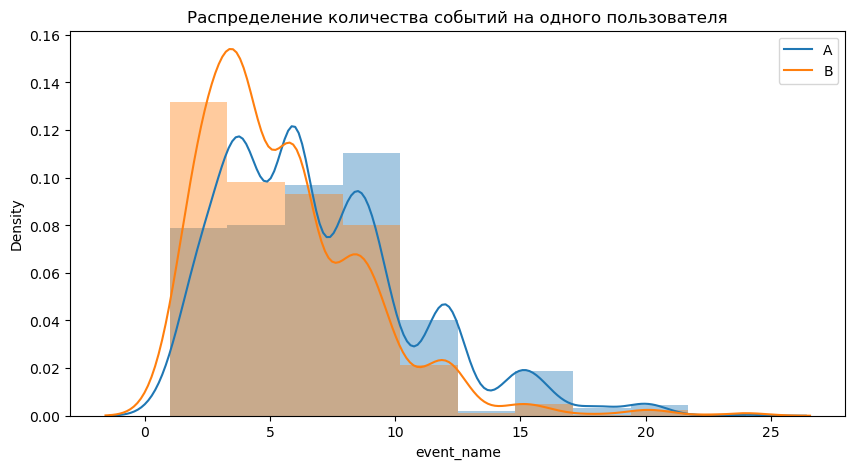

In [87]:
distribution_A = group_A.pivot_table(index=['user_id'],values='event_name',aggfunc='count').reset_index()
distribution_B = group_B.pivot_table(index=['user_id'],values='event_name',aggfunc='count').reset_index()
# строим график
plt.figure(figsize=(10, 5))
sns.distplot(distribution_A['event_name'], bins=10)
sns.distplot(distribution_B['event_name'], bins=10)
plt.legend(labels = ('A', 'B'))
plt.title('Распределение количества событий на одного пользователя')
plt.show()

На графике видим, что среднее число взаимодействий на одного пользователя у группы А больше, чем в группе В. Группы обладают различным распределением взаимодействий, и разными средним количеством событий на одного пользователя.

- Распределение событий по датам:

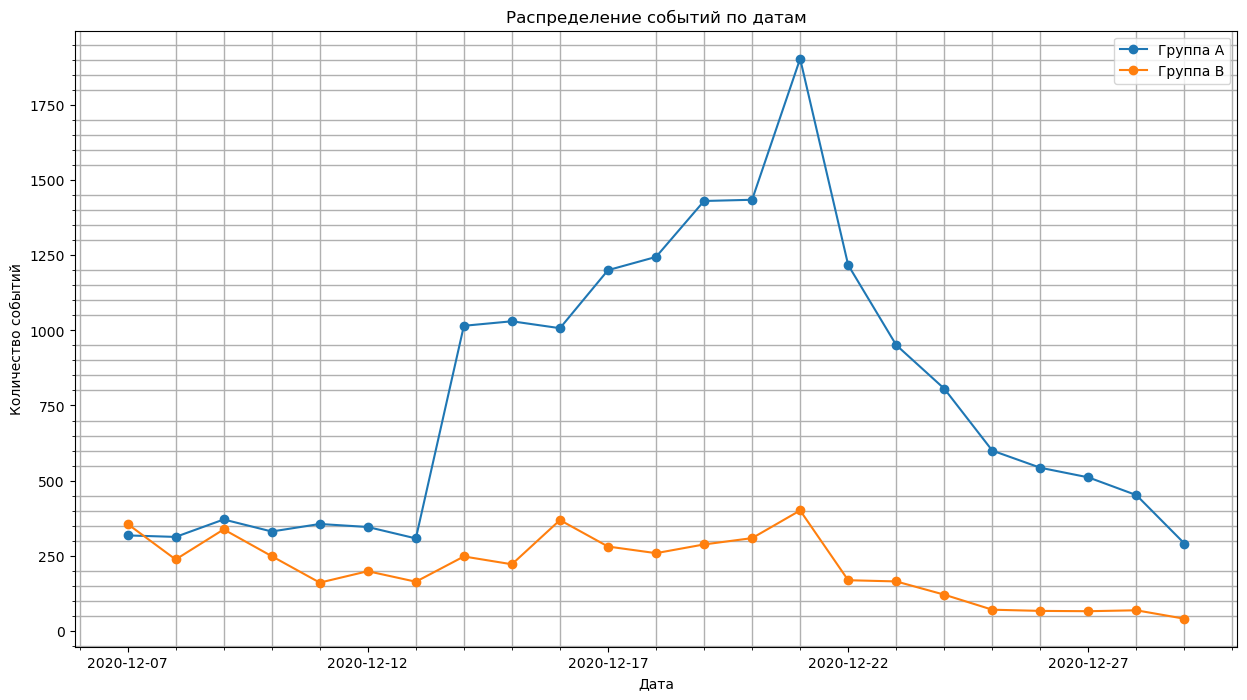

In [88]:
# подготовим сводную таблицу для грфиков
data_date = data.pivot_table(index=['event_dt', 'group'], values='event_name', aggfunc='count').reset_index(level='group')
# построим графики
plt.figure(figsize=(15, 8))                                                                # создаём полотно графика
plt.minorticks_on()                                                                        # включаем второстепенные деления сетки
plt.grid(which = 'minor', linewidth = 1)                                                   # изменяем параметры второстепенной сетки
plt.grid(which = 'major', linewidth = 2)                                                   # изменяем параметры основной сетки
data_date[data_date['group'] == 'A']['event_name'].plot(label='Группа А', marker ='o')     # построим график для группы А 
data_date[data_date['group'] == 'B']['event_name'].plot(label='Группа В', marker ='o')     # построим график для группы В
plt.legend()                                                                               # включаем блок с отображением надписей 
plt.title('Распределение событий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()                                                                                 # выводим график на экран

На графике видим неравномерное распределение событий по датам в группах. В группе А наблюдается наибольшее количество событий 21 декабря. В группе В - распределение равномерное.

### 5. Исследование конверсии в воронке на разных этапах

In [89]:
# подготовим данные для создания воронки по группам для каждого события
login_a = group_A.query('event_name == "login"')                        # отберём события со входом из таблицы группы А
login_a_users = np.asarray(login_a['user_id'].unique())                 # конвертируем матрицу А в массив
login_b = group_B.query('event_name == "login"')                        # отберём события со входом из таблицы группы B
login_b_users = np.asarray(login_b['user_id'].unique())                 # конвертируем матрицу B в массив

product_page_a = group_A.query('event_name == "product_page"')          # отберём события с просмотром карточки товара из таблицы группы А
product_page_a_users = np.asarray(product_page_a['user_id'].unique())   # конвертируем матрицу А в массив
product_page_b = group_B.query('event_name == "product_page"')          # отберём события с просмотром карточки товара из таблицы группы В
product_page_b_users = np.asarray(product_page_b['user_id'].unique())   # конвертируем матрицу В в массив
                                  
product_cart_a = group_A.query('event_name == "product_cart"')          # отберём события с корзиной из таблицы группы А
product_cart_a_users = np.asarray(product_cart_a['user_id'].unique())   # конвертируем матрицу А в массив
product_cart_b = group_B.query('event_name == "product_cart"')          # отберём события с корзиной из таблицы группы В
product_cart_b_users = np.asarray(product_cart_b['user_id'].unique())   # конвертируем матрицу В в массив
                                  
purchase_a = group_A.query('event_name == "purchase"')                  # отберём события с покупкой товара из таблицы группы А
purchase_a_users = np.asarray(purchase_a['user_id'].unique())           # конвертируем матрицу А в массив
purchase_b = group_B.query('event_name == "purchase"')                  # отберём события с покупкой товара из таблицы группы В
purchase_b_users = np.asarray(purchase_b['user_id'].unique())           # конвертируем матрицу В в массив

In [90]:
# построим воронку событий с разделением по группам
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y=['Вход в систему', 'Просмотр карточек товаров', 'Корзина', 'Покупка'],
    x=[len(login_a_users), len(product_page_a_users), len(product_cart_a_users), len(purchase_a_users)], 
    marker={'color':'orange'}))

fig.add_trace(go.Funnel(
    name = 'Группа В',
    y=['Вход в систему', 'Просмотр карточек товаров', 'Корзина', 'Покупка'],
    x=[len(login_b_users), len(product_page_b_users), len(product_cart_b_users), len(purchase_b_users)], 
    marker={'color':'green'}))
# выводим воронку на экран
fig.show()

Все пользователи из групп А и В совершили вход в систему это 100%. Просмотр карточек товаров из группы А совершили 64,8%, из группы В 56,4%. В корзину перешли 30% и 27,5%. Покупку А - 331,7%, В - 27,6% от общего числа соответственно.

Пользователи в обоих группах иногда покупают прямо со страницы товара, обходя шаг с просмотром корзины.

###  6. A/B-тестирование

Проверим статистическую разницу долей `z-критерием`:

- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

In [91]:
alpha = 0.05 # критический уровень статистической значимости

def z_test(successes, trials): 
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между выборками есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными')

- Проведём тест на проверку гипотезы о равенстве долей:

**Нулевая гипотеза H0**: конверсии из шага в шаг в выборках равны

**Альтернативная гипотезаH1**: конверсии из шага в шаг в выборках разные

In [92]:
# расчитаем p-значение для события просмотра карточек
successes_page = np.array([len(product_page_a_users), len(product_page_b_users)])
trials_page = np.array([len(login_a_users), len(login_b_users)])
z_test(successes_page, trials_page)

p-значение:  8.195976000324734e-06
Отвергаем нулевую гипотезу: между выборками есть значимая разница


In [93]:
# расчитаем p-значение для события корзина
successes_cart = np.array([len(product_cart_a_users), len(product_cart_b_users)])
trials_cart = np.array([len(product_page_a_users), len(product_page_b_users)])
z_test(successes_cart, trials_cart)

p-значение:  0.2276722007959906
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными


In [94]:
# расчитаем p-значение для события покупка товара
successes_purchase = np.array([len(purchase_a_users), len(purchase_b_users)])
trials_purchase = np.array([len(product_page_a_users), len(product_page_b_users)])
z_test(successes_purchase, trials_purchase)

p-значение:  0.6757323469354453
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными


Конверсия с первой страницы со входом в событие просомтра карточек товаров между группами А и В отличается. В последующих шагах конверсия между выборками не имеет статистических отличий.

Ожидаемый эффект: за 14 дней с момента регистрации пользователи не показали улучшение каждой метрики не менее, чем на 10%. Это связано:
1. С разным количеством пользователей в группах;
2. Разное распределение количества событий в группах;
3. Ожидаемое количество участников теста не соотвествует ТЗ (3675 активных пользователей из необходимых 6000)

## 7. Общий вывод:

Корректность проведения теста можно оценить как не очень высокую.
- Ожидаемое количество участников теста не соотвествует ТЗ (3675 активных пользователей из необходимых 6000);
- Распределение пользователей по группам неравномерное, группа А в полтора раза больше В;
- Во время набора пользователей на тест проходили 2 маркетинговых мероприятия в период с 25 декабря до 3 января - рождественское и новогоднее промо в Европе и Североной Америке. И новогодняя лотерея в СНГ. Возможно, эти акции повлияли на активность пользователей в последнюю неделю теста;
- События в собранных данных обрываются раньше озвученного окончания теста, т.е. с 29 декабря 2020 года, скорее всего произошел какой-то сбой в записи событий и убрали их.

Таким образом, условия, указанные в техническом задании, не выполнены.

Кроме того, пользователи, попавшие в разные группы, проявляют разную активность в приложении, в группе B пользователи совершают меньше действий, чем в группе А. По конверсии на каждом этапе группа B заметно проигрывает группе А. Статистические значимые различия между группами есть только на этапе просмотров карточек товаров, а при просмотре корзины и при покупках статистически значимых различий нет. Таким образом, можно сделать вывод, что ожидаемого эффекта улучшенная рекомендательная система не достигла.

**Примечание**: 

Можно было бы сравнять группу А и В по количеству пользователей для `повторного` А/В анализа, но распределение событий в группе А не позволяют это сделать.

**Рекомендации:** 

Так как условия ТЗ не выполнены в полном объёме, то тестирование нельзя считать корректным, его необходимо провести на новых данных.